# FINAL PROJECT (CPE 646: PATTERN RECOGNITION AND CLASSIFICATION)

## Pneumonia Detection using Transfer Learning on Chest X-ray Image Dataset

Shreeya Kokate (CWID: 20005256)

Abhishek Amberkar (CWID: 10469370)

Pranavi Vashishtha (CWID: 10459638)

# Importing data and necessary libraries

In [ ]:
import os
import random
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
import glob
import cv2

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.random import set_seed
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import tensorflow as tf

tf.test.gpu_device_name()

pd.options.display.max_colwidth = 100

from numpy.random import seed
seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

Loading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dir = "/content/drive/MyDrive/CPE 646/InitialData/train"
test_dir = "/content/drive/MyDrive/CPE 646/InitialData/test"
val_dir = "/content/drive/MyDrive/CPE 646/InitialData/val"



Basic Data information

In [ ]:
print("Training Dataset:")
print("-" * 50)
trpneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
trnormal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA = {trpneumonia}")
print(f"NORMAL = {trnormal}")

print("\nTesting Dataset:")
print('-' * 50)
print(f"PNEUMONIA = {len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL = {len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

print("\nValidation Dataset:")
print('-' * 50)
print(f"PNEUMONIA = {len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL = {len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")


Training Dataset:
--------------------------------------------------
PNEUMONIA = 3886
NORMAL = 1342

Testing Dataset:
--------------------------------------------------
PNEUMONIA = 390
NORMAL = 234

Validation Dataset:
--------------------------------------------------
PNEUMONIA = 9
NORMAL = 9


In [ ]:
trnormal = os.listdir("/content/drive/MyDrive/CPE 646/InitialData/train/NORMAL")
trnormal_dir = "/content/drive/MyDrive/CPE 646/InitialData/train/NORMAL"
trpneumonia = os.listdir("/content/drive/MyDrive/CPE 646/InitialData/train/PNEUMONIA")
trpneumonia_dir = "/content/drive/MyDrive/CPE 646/InitialData/train/PNEUMONIA"

In [ ]:
pneumonia_train = glob.glob(train_dir + "/PNEUMONIA/*.jpeg")
normal_train = glob.glob(train_dir + "/NORMAL/*.jpeg")

pneumonia_test = glob.glob(test_dir + "/PNEUMONIA/*.jpeg")
normal_test = glob.glob(test_dir + "/NORMAL/*.jpeg")

# Data Visualization

X-ray images having PNEUMONIA

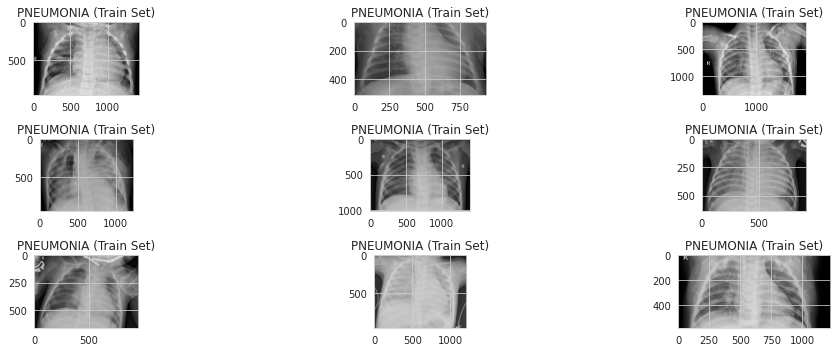

In [ ]:
plt.figure(figsize = (15, 5))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(trpneumonia_dir, trpneumonia[i]))
    plt.title("PNEUMONIA (Train Set)")
    plt.imshow(img, cmap='gray')
    
plt.tight_layout()

NORMAL X-ray images

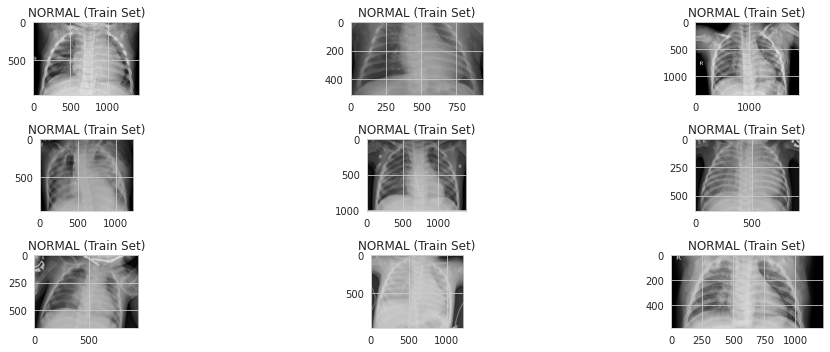

In [ ]:
plt.figure(figsize=(15, 5))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(trpneumonia_dir, trpneumonia[i]))
    plt.title("NORMAL (Train Set)")
    plt.imshow(img, cmap='gray')
    
plt.tight_layout()

Creating dataframe for counting classes.

In [ ]:
data = pd.DataFrame(np.concatenate([[0] * len(normal_train) , [1] * len(pneumonia_train)]), columns = ["class"])

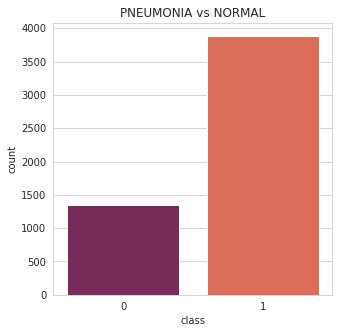

In [ ]:
plt.figure(figsize = (5, 5))
sns.countplot(data['class'], data = data, palette = 'rocket')
plt.title('PNEUMONIA vs NORMAL')
plt.show()

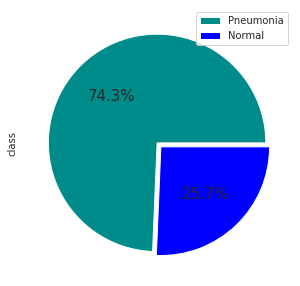

In [ ]:
plt.figure(figsize = (5,5))

data['class'].value_counts().plot(kind = 'pie', labels = ['',''], autopct = '%1.1f%%', colors = ['darkcyan','blue'], explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['Pneumonia', 'Normal'])
plt.show()

# Defining the model

## Custom CNN

In [ ]:
train_list = [x for x in normal_train]
train_list.extend([x for x in pneumonia_train])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(normal_train) , ['Pneumonia']*len(pneumonia_train)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in normal_test]
test_list.extend([x for x in pneumonia_test])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(normal_test) , ['Pneumonia']*len(pneumonia_test)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

In [ ]:
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = 42, stratify = df_train['class'])

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1/255., zoom_range = 0.1, width_shift_range = 0.1, height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale = 1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df, x_col = 'image', y_col = 'class', target_size = (224, 224), class_mode = 'binary', batch_size = 32, seed = 42)

ds_val = val_datagen.flow_from_dataframe(val_df, x_col = 'image', y_col = 'class', target_size = (224, 224), class_mode = 'binary', batch_size = 32, seed = 42)

ds_test = val_datagen.flow_from_dataframe(df_test, x_col = 'image', y_col = 'class', target_size = (224, 224), class_mode = 'binary', batch_size = 32)

Found 4180 validated image filenames belonging to 2 classes.
Found 1046 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [ ]:
# Defining Callbacks
early_stopping = callbacks.EarlyStopping( monitor = 'val_loss',patience = 5, min_delta = 1e-7, restore_best_weights = True)

plateau = callbacks.ReduceLROnPlateau( monitor='val_loss', factor = 0.2, patience = 2, min_delt = 1e-7, cooldown = 0, verbose = 1) 

In [ ]:
def get_model():
    inputs = keras.layers.Input(shape = (224, 224, 3))
    
    # Layer 1
    x = keras.layers.Conv2D(filters = 16, kernel_size = 3, padding = 'valid')(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPool2D()(x)
    x = keras.layers.Dropout(0.2)(x)

    # Layer 2
    x = keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPool2D()(x)
    x = keras.layers.Dropout(0.2)(x)
    
    # Layer 3
    x = keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'valid')(x)
    x = keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPool2D()(x)
    x = keras.layers.Dropout(0.4)(x)

    # Head Layer
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(64, activation = 'relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    
    #Final Layer
    output = keras.layers.Dense(1, activation = 'sigmoid')(x)
    model = keras.Model(inputs = [inputs], outputs = output)
    
    return model

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
model = get_model()

model.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.Adam(learning_rate = 3e-5), metrics = 'binary_accuracy')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 222, 222, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 16)      0     

In [ ]:
history = model.fit(ds_train,
          batch_size = 32, epochs = 10,
          validation_data = ds_val,
          callbacks = [early_stopping, plateau],
          steps_per_epoch = (len(train_df)/32),
          validation_steps = (len(val_df)/32));

Epoch 1/10
130/130 [==============================] - 142s 1s/step - loss: 0.5368 - binary_accuracy: 0.7505 - val_loss: 0.8239 - val_binary_accuracy: 0.7438 - lr: 3.0000e-05
Epoch 2/10
130/130 [==============================] - 134s 1s/step - loss: 0.3660 - binary_accuracy: 0.8306 - val_loss: 1.4982 - val_binary_accuracy: 0.7438 - lr: 3.0000e-05
Epoch 3/10
131/130 [==============================] - ETA: 0s - loss: 0.2854 - binary_accuracy: 0.8701
Epoch 3: ReduceLROnPlateau reducing learning rate to 5.9999998484272515e-06.
130/130 [==============================] - 128s 977ms/step - loss: 0.2854 - binary_accuracy: 0.8701 - val_loss: 1.5503 - val_binary_accuracy: 0.7438 - lr: 3.0000e-05
Epoch 4/10
130/130 [==============================] - 130s 995ms/step - loss: 0.2453 - binary_accuracy: 0.8926 - val_loss: 1.2246 - val_binary_accuracy: 0.7438 - lr: 6.0000e-06
Epoch 5/10
130/130 [==============================] - 130s 996ms/step - loss: 0.2367 - binary_accuracy: 0.8993 - val_loss: 0.6245

In [ ]:
score1_val = model.evaluate(ds_val, steps = 100, verbose = 0)

print('Validation set loss:', score1_val[0])
print('Validation set accuracy:', score1_val[1])

Validation set loss: 0.18721286952495575
Validation set accuracy: 0.9369024634361267


In [ ]:
score1_test = model.evaluate(ds_test, steps = 100, verbose = 0)

print('Test loss:', score1_test[0])
print('Test accuracy:', score1_test[1])

Test loss: 0.6109903454780579
Test accuracy: 0.7804487347602844


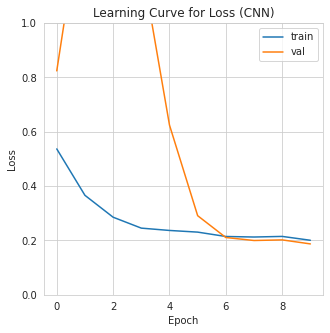

In [ ]:
fig, ax = plt.subplots(figsize = (5, 5))

sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])

ax.set_title('Learning Curve for Loss (CNN)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 1)
ax.legend(['train', 'val'], loc = 'best')
plt.show()

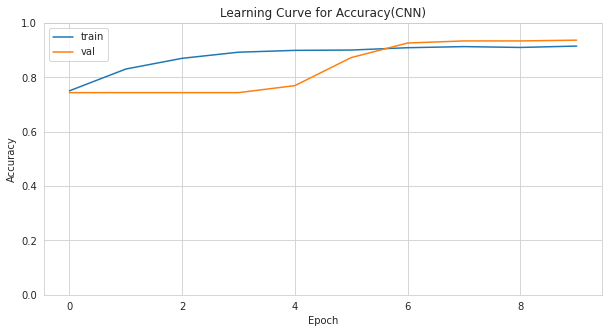

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])

ax.set_title('Learning Curve for Accuracy(CNN)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 1)
ax.legend(['train', 'val'], loc = 'best')
plt.show()

## VGG

Data Augmentation

In [ ]:
train_DA = ImageDataGenerator(
        rescale = 1/255,
        shear_range = 10,
        zoom_range = 0.1,
        horizontal_flip = True,
        vertical_flip = True,
        brightness_range = [0.5, 2.0],
        width_shift_range = 0.1,
        rotation_range = 20,
        fill_mode = 'nearest')


val_DA = ImageDataGenerator(
        rescale = 1/255)

In [ ]:
train = train_DA.flow_from_directory(train_dir, batch_size = 32, class_mode = 'binary') 

validation = val_DA.flow_from_directory(val_dir, batch_size = 32, class_mode = 'binary')

test = val_DA.flow_from_directory(test_dir, batch_size = 32, class_mode = 'binary')

In [ ]:
img, label = next(train)

In [ ]:
vgg_model = tf.keras.applications.VGG19(weights = 'imagenet', include_top = False)

for layer in vgg_model.layers:
    layer.trainable = False
    
x = vgg_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)

# output layer
predictions = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
model2 = tf.keras.Model(inputs = vgg_model.input, outputs = predictions)

# to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience = 8)

# Compiling the model
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [ ]:
history = model2.fit(train, epochs = 10, 
                    validation_data = validation,
                     steps_per_epoch = 100,
                    callbacks = [early_stopping, lr],
                    batch_size = 32)

Epoch 1/10
100/100 [==============================] - 245s 2s/step - loss: 0.5383 - accuracy: 0.7434 - val_loss: 0.6220 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 2/10
100/100 [==============================] - 225s 2s/step - loss: 0.4258 - accuracy: 0.8030 - val_loss: 0.5137 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 3/10
100/100 [==============================] - 225s 2s/step - loss: 0.3965 - accuracy: 0.8228 - val_loss: 0.4968 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 4/10
100/100 [==============================] - 225s 2s/step - loss: 0.3465 - accuracy: 0.8497 - val_loss: 0.5388 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 5/10
100/100 [==============================] - 226s 2s/step - loss: 0.3403 - accuracy: 0.8543 - val_loss: 0.5909 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 6/10
100/100 [==============================] - 228s 2s/step - loss: 0.3148 - accuracy: 0.8634 - val_loss: 0.3885 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 7/10
100/100 [==============================] - 226s 2s/st

Evaluating the VGG19

In [ ]:
# Evaluating the model on Train data  
score2_train = model2.evaluate(train)

print("Training Set Loss: ", score2_train[0])
print("Training Set Accuracy: ", score2_train[1])

164/164 [==============================] - 370s 2s/step - loss: 0.2416 - accuracy: 0.9018
Training Set Loss:  0.24156710505485535
Training Set Accuracy:  0.9018369913101196


In [ ]:
# Evaluating the model on Test data
score2_test = model2.evaluate(test)

print("Testing Set Loss: ", score2_test[0])
print("Testing Set Accuracy: ", score2_test[1])

20/20 [==============================] - 34s 2s/step - loss: 0.4660 - accuracy: 0.7740
Testing Set Loss:  0.46601343154907227
Testing Set Accuracy:  0.7740384340286255


Text(0.5, 1.0, 'Learning Curve for Accuracy (VGG-19)')

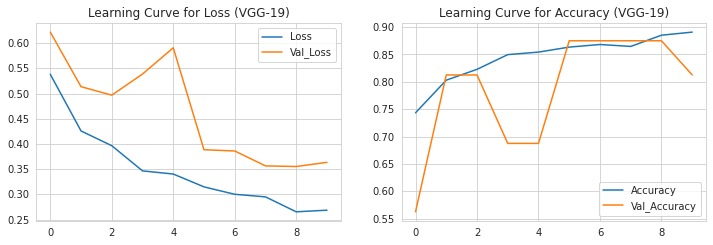

In [ ]:
plt.figure(figsize = (12, 8))
plt.title('EVALUATION OF VGG19')

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label = 'Loss')
plt.plot(history.history['val_loss'], label = 'Val_Loss')
plt.legend()
plt.title('Learning Curve for Loss (VGG-19)')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label = 'Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val_Accuracy')
plt.legend()
plt.title('Learning Curve for Accuracy (VGG-19)')

## ResNet50V2

In [ ]:
resnet_model = tf.keras.applications.ResNet50V2(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))

for layer in resnet_model.layers:
    layer.trainable = False
    
x = resnet_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation = 'relu')(x)

# output layer
predictions = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
model3 = tf.keras.Model(inputs = resnet_model.input, outputs = predictions)

# to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 6)

# Compiling the model
model3.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

94683136/94668760 [==============================] - 1s 0us/step


In [ ]:
history = model3.fit(train, epochs = 10, 
                    validation_data = validation,
                     steps_per_epoch = 100,
                    callbacks = [early_stopping, lr],
                    batch_size = 32)

Epoch 1/10
100/100 [==============================] - 132s 1s/step - loss: 0.2804 - accuracy: 0.8853 - val_loss: 0.1498 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 2/10
100/100 [==============================] - 126s 1s/step - loss: 0.1571 - accuracy: 0.9368 - val_loss: 0.1308 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 3/10
100/100 [==============================] - 125s 1s/step - loss: 0.1477 - accuracy: 0.9402 - val_loss: 0.2003 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 4/10
100/100 [==============================] - 123s 1s/step - loss: 0.1406 - accuracy: 0.9456 - val_loss: 0.1958 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 5/10
100/100 [==============================] - 130s 1s/step - loss: 0.1518 - accuracy: 0.9374 - val_loss: 0.2857 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 6/10
100/100 [==============================] - 129s 1s/step - loss: 0.1325 - accuracy: 0.9484 - val_loss: 0.1190 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 7/10
100/100 [==============================] - 126s 1s/st

In [ ]:
# Evaluating the model on train and test
score3_train = model3.evaluate(train)
print("Train Loss: ", score3_train[0])
print("Train Accuracy: ", score3_train[1])

score3_test = model3.evaluate(test)
print("\nTest loss: ", score3_test[0])
print("Test Accuracy: ", score3_test[1])

164/164 [==============================] - 196s 1s/step - loss: 0.1062 - accuracy: 0.9577
Train Loss:  0.10620119422674179
Train Accuracy:  0.9577114582061768
20/20 [==============================] - 13s 630ms/step - loss: 0.3015 - accuracy: 0.8830

Test loss:  0.301524817943573
Test Accuracy:  0.8830128312110901


Text(0.5, 1.0, 'Learning Curve for Accuracy (ResNet50)')

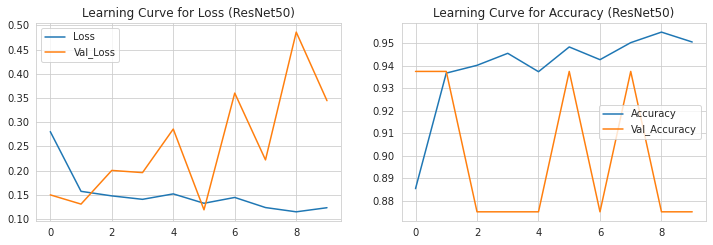

In [ ]:
plt.figure(figsize = (12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label = 'Loss')
plt.plot(history.history['val_loss'], label = 'Val_Loss')
plt.legend()
plt.title('Learning Curve for Loss (ResNet50)')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label = 'Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val_Accuracy')
plt.legend()
plt.title('Learning Curve for Accuracy (ResNet50)')

## Fine Tuning ResNet50

In [ ]:
resnet_model.trainable = True

In [ ]:
# Check number of layers in the base model
print("Number of layers in the base model: ", len(resnet_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in resnet_model.layers[: fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  190


In [ ]:
# Compiling the model
model3.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
len(model3.trainable_variables)

86

In [ ]:
fine_tune_epochs = 5
epochs_on_raw_model = 5

total_epochs =  epochs_on_raw_model + fine_tune_epochs

In [ ]:
history_fine = model3.fit(train,epochs = total_epochs, 
                    validation_data = validation,
                    steps_per_epoch = 100,
                    callbacks = [early_stopping, lr],
                    batch_size = 32)

Epoch 1/10
100/100 [==============================] - 158s 2s/step - loss: 0.2539 - accuracy: 0.9034 - val_loss: 1.3213 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/10
100/100 [==============================] - 151s 2s/step - loss: 0.1527 - accuracy: 0.9449 - val_loss: 0.1706 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 3/10
100/100 [==============================] - 152s 2s/step - loss: 0.1224 - accuracy: 0.9588 - val_loss: 0.0459 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/10
100/100 [==============================] - 152s 2s/step - loss: 0.1233 - accuracy: 0.9591 - val_loss: 0.1345 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/10
100/100 [==============================] - 154s 2s/step - loss: 0.1057 - accuracy: 0.9619 - val_loss: 0.1391 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/10
100/100 [==============================] - 161s 2s/step - loss: 0.0940 - accuracy: 0.9641 - val_loss: 0.0225 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/10
100/100 [==============================] - 163s 2s/st

Evaluating the Fine Tune model

In [ ]:
# Evaluating the model on train and test
score4_train = model3.evaluate(train)
print("Train Loss: ", score4_train[0])
print("Train Accuracy: ", score4_train[1])

score4_test = model3.evaluate(test)
print("\nTest loss: ", score4_test[0])
print("Test Accuracy: ", score4_test[1])

164/164 [==============================] - 205s 1s/step - loss: 0.4136 - accuracy: 0.8990
Train Loss:  0.41361093521118164
Train Accuracy:  0.8989667296409607
20/20 [==============================] - 14s 673ms/step - loss: 0.5895 - accuracy: 0.8782

Test loss:  0.5894671082496643
Test Accuracy:  0.8782051205635071


Text(0.5, 1.0, 'Learning Curve for Accuracy (ResNet50 FineTuned)')

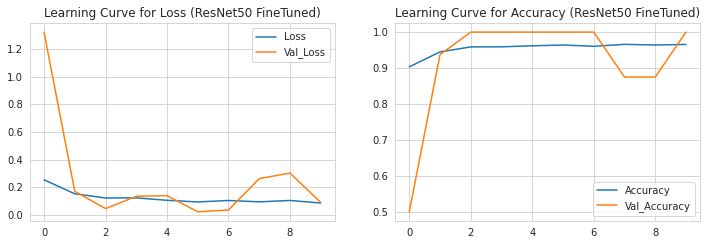

In [ ]:
plt.figure(figsize = (12, 8))

plt.subplot(2, 2, 1)
plt.plot(history_fine.history['loss'], label = 'Loss')
plt.plot(history_fine.history['val_loss'], label = 'Val_Loss')
plt.legend()
plt.title('Learning Curve for Loss (ResNet50 FineTuned)')

plt.subplot(2, 2, 2)
plt.plot(history_fine.history['accuracy'], label = 'Accuracy')
plt.plot(history_fine.history['val_accuracy'], label = 'Val_Accuracy')
plt.legend()
plt.title('Learning Curve for Accuracy (ResNet50 FineTuned)')